#    This notebook is an exploration of Cambridge, Massachusettes bike data
#### Part 1: A brief look at the demographics of bikers of Cambridge and how biking in Cambridge has changed over time
#### Part 2: A more in depth look at crashes involving bicycles over time. 

### Log of data included in this project
#### - transport_data: Labor Force Commuting Mode Split: 1990, 2000, 2006 - 2010, and 2012 - 2016. From data.cambridgema.gov: "This data set compares 1990, 2000, 2006 - 2010, and 2012-16 Journey to Work data, outlining the modes of commuting for the Labor Force of the City of Cambridge, regardless of workplace location. The data set originates from three sources: 1990 Journey to Work data supplied to the Massachusetts Central Transportation Planning Staff by the Census Bureau, a special tabulation of 2000 Decennial Census data - the 2000 Census Transportation Planning Products (CTPP), and the two most recent versions of the CTPP compiled from the American Community Survey. The Cambridge Labor Force consist of all Cambridge residents who work or who are currently seeking work, regardless of workplace location." https://data.cambridgema.gov/Transportation-Planning/Labor-Force-Commuting-Mode-Split-1990-2000-2006-20/8acn-zxjt
#### - new_crash_data: List of crashes involving motor vehicles, bicycles and/or pedestrians reported in the City of Cambridge since 2015. https://data.cambridgema.gov/Public-Safety/Police-Department-Crash-Data-Updated/gb5w-yva3
#### - nbr_data: Blockgroup data from the 2013-2017 American Community Survey was recompiled by the Cambridge Community Development Department to align with approximate neighborhood boundaries. Categories include: Total Population, Language Spoken at Home by Population 5 and Older, Educational Attainment by Population 25 and Older, Means of Commute for Resident Workers, Vehicles Owned by Household, Per Capita Income, and Poverty Rates. https://data.cambridgema.gov/Neighborhood-Census-Data/American-Community-Survey-2013-17-Estimates-by-Nei/m9gy-vc6p
#### - broad_bike_count: The “Eco-Totem” counter (made by the Montreal-based company Eco-Counter) counts cyclists via in-ground loop detectors embedded under the pavement of Broadway near Kendall Square. Start: 6/24/2015 End: 10/27/2019 https://data.cambridgema.gov/dataset/Eco-Totem-Broadway-Bicycle-Count/q8v9-mcfg


In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
from bs4 import BeautifulSoup
import requests
import math
import calendar as calendar

In [2]:
# This cell imports all datasets used in this data exploration
trans_data = pd.read_csv('Labor_Force_Commuting.csv')

crash_data = pd.read_csv('Police_crash_data.csv')

nbr_data = pd.read_csv('Neighborhood_economic_data.csv')

broad_bike_count = pd.read_csv('Broadway_bike_count.csv')



//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (81,110,115) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# this cell webscrapes monthly weather data for Cambridge
page = requests.get("https://www.areavibes.com/cambridge-ma/weather/")
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find(class_ = "av-default").get_text()

month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
              'August', 'September', 'October', 'November', 'December']
num_month_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# find each month in the scraped table and collect the corresponding temperature and precipitation data
max_temp = []
min_temp = []
avg_temp = []
avg_precip = []

for month in month_list:
    start = table.index(month)+len(month)
    min_temp.append(int(table[start:start+2]))
    max_temp.append(int(table[start+4:start+6]))
    avg_temp.append(int(table[start+8:start+10]))
    avg_precip.append(float(table[start+12:start+15]))

monthly_weather = pd.DataFrame({"Month": month_list, "Month Number": num_month_list, "Min Temp": min_temp, "Max Temp": max_temp, "Avg Temp": avg_temp, "Avg Precipitation": avg_precip})
monthly_weather.head()
        

,Month,Month Number,Min Temp,Max Temp,Avg Temp,Avg Precipitation
0,January,01,23,40,31,3.2
1,February,02,22,41,31,3.2
2,March,03,29,48,38,3.8
3,April,04,40,61,49,3.7
4,May,05,50,69,58,3.8


## Part 1: Biker demographics and changes over time

In [4]:
# begin investigation by comparing citywide data by year 
city_trans_data  = trans_data.loc[trans_data['Census Tract'] == 'Citywide']
city_trans_data.head(4)


,Census Tract,Year,Population,Total Laborforce,% of Total Laborforce,Drove Alone,Carpool,Public Transit,Bike,Walk,Other Mode,Work at Home
0,Citywide,1990,95802,52355,100.0,37.7,7.5,23.4,2.9,24.2,0.9,3.4
1,Citywide,2000,101355,54979,100.0,35.3,5.2,24.9,3.9,24.3,1.1,5.3
2,Citywide,2006-2010,103506,56910,100.0,30.7,4.6,28.1,6.8,22.7,1.1,6.1
131,Citywide,2012-2016,108755,61930,100.0,28.2,3.5,28.9,7.0,24.6,1.0,6.8


### Comparision of the population of Cambridge vs different commute methods

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

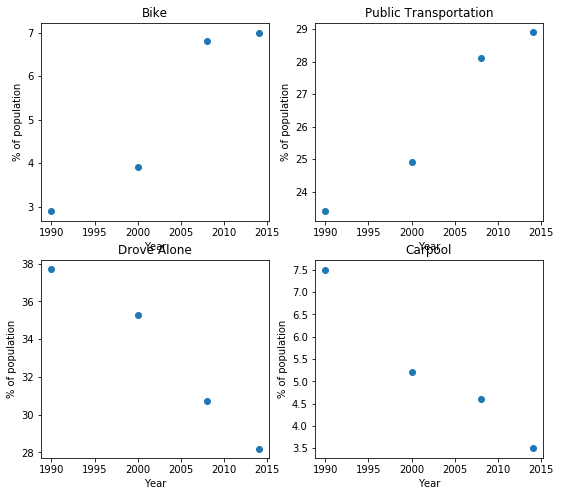

In [35]:
# plot popularity of different commuting methods over time
rcParams['figure.figsize'] = 9, 8

# some data is from specific year (1990, 2000), some data is from a range of years (2006-2010)
# to compare, the middle year of the range was selected, ie 2006-2010 is represented by 2008
years = [1990, 2000, 2008, 2014]

rcParams['figure.figsize'] = 9, 8

# plot will look at % of Camb residents who bike, take public transit, drive alone and carpool
plt.subplot(2,2,1)
plt.scatter(years,city_trans_data['Bike'])
plt.xlabel('Year')
plt.ylabel('% of population')
plt.title('Bike')

plt.subplot(2,2,2)
plt.scatter(years, city_trans_data['Public Transit'])
plt.title('Public Transportation')
plt.xlabel('Year')
plt.ylabel('% of population')

plt.subplot(2,2,3)
plt.scatter(years, city_trans_data['Drove Alone'])
plt.title('Drove Alone')
plt.xlabel('Year')
plt.ylabel('% of population')

plt.subplot(2,2,4)
plt.scatter(years,city_trans_data['Carpool'])
plt.title('Carpool')
plt.xlabel('Year')
plt.ylabel('% of population')

plt.tight_layout

#### As the population of Cambridge has grown, the percentage of the population commuting via bicycle and public transit has also increased. The percentage of Cambridge residents carpooling and driving by themselves to work has decreased. Overall Cambridge residents are commuting less by car and more by alternate means of transportation than they were 20, 10, and even 5 years ago.

In [6]:
broad_bike_count.head()

,DateTime,Day,Date,Time,Total,Westbound,Eastbound
0,06/24/2015 12:00:00 AM,Wednesday,06/24/2015,00:00:00,4,1,3
1,06/24/2015 12:15:00 AM,Wednesday,06/24/2015,00:15:00,3,3,0
2,06/24/2015 12:30:00 AM,Wednesday,06/24/2015,00:30:00,4,3,1
3,06/24/2015 12:45:00 AM,Wednesday,06/24/2015,00:45:00,2,2,0
4,06/24/2015 01:00:00 AM,Wednesday,06/24/2015,01:00:00,2,2,0


In [7]:
# broad_bike_count records the number of bikers that passed the counter in 15 minute increments
# compile counter data to have breakdown by date 

pd.to_datetime(broad_bike_count['Date'])
broad_bike_count = broad_bike_count.sort_values(by='Date')
date_col = broad_bike_count['Date']
count_col = broad_bike_count['Total']

dow_col = broad_bike_count['Day']
dow_dict = {'Sunday': [0,0], 'Monday': [0,0], 'Tuesday': [0,0], 'Wednesday': [0,0], 'Thursday': [0,0], 'Friday': [0,0], 'Saturday': [0,0]}

prev_date = date_col.iloc[1]
prev_count = 0
date_list = []
count_list = []

# count the number of bike rides each day
# if the current row is from the same date as the previous, 
# then add the counts together, else start new count
for i in range(len(date_col)):
    curr_date = date_col.iloc[i]
    curr_count = int(count_col.iloc[i])
    curr_dow = dow_col.iloc[i]
    
    if curr_date == prev_date:
        curr_count += prev_count
        
    else:
        date_list.append(prev_date)
        count_list.append(prev_count)
        
    prev_date = curr_date
    prev_count = curr_count
    
    # also count for days of week
    dow_rider_count = dow_dict[curr_dow][0] + curr_count
    dow_count = dow_dict[curr_dow][1] + 1
    dow_dict[curr_dow] = [dow_rider_count, dow_count]

# create a dataframe containing every date and the bike count on that date
daily_bike_count = pd.DataFrame({'Date':date_list, 'Count': count_list})

daily_bike_count.head(5)

,Date,Count
0,01/01/2016,157
1,01/01/2017,124
2,01/01/2018,40
3,01/01/2019,169
4,01/02/2016,192


{'Sunday': 209, 'Monday': 663, 'Tuesday': 692, 'Wednesday': 733, 'Thursday': 730, 'Friday': 617, 'Saturday': 252}


Text(0.5, 1.0, 'Average number of bike rides by day of week')

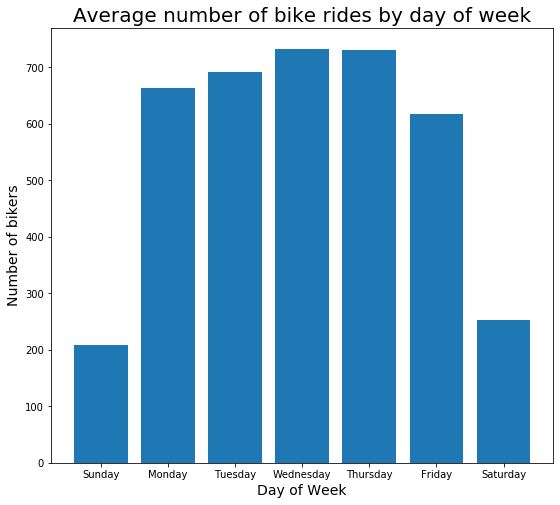

In [8]:
# dow_dict is a dictionary where keys are days of the week and values are a list of total number of riders on that day
# and the number of times that day was counted. ie. Saturday:[100, 10] means 100 riders were counted over 10 saturdays
# want to normalize to determine the average number of daily riders for each day of the week

dow_dict_daily = {'Sunday': 0, 'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 0}

for day in dow_dict:

    daily_riders = dow_dict[day][0] / dow_dict[day][1]
    dow_dict_daily[day] = int(daily_riders)

print(dow_dict_daily)
dow = list(dow_dict_daily.keys())
dow_count = list(dow_dict_daily.values())

plt.bar(dow, dow_count)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Number of bikers',fontsize=14)
plt.title('Average number of bike rides by day of week', fontsize=20)

## The week days have higher number of bike riders than the weekend days, likely because many bike riders are commuting to work and do not have to work on the weekends

Text(0.5, 1.0, 'Daily Riders past Broadway St. Bicycle Counter Station')

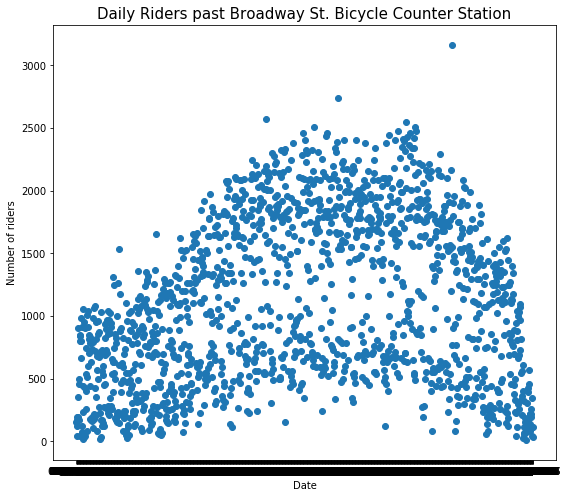

In [9]:
plt.scatter(daily_bike_count['Date'], daily_bike_count['Count'])
plt.xlabel('Date')
plt.ylabel('Number of riders')
plt.title('Daily Riders past Broadway St. Bicycle Counter Station', fontsize=15)

In [10]:
# this is a lot of data points, want to switch to average number of bikers per month instead
# some months are missing days, likely because of counter maintenance
# for every row in the list of bike counts per date, count by month 

date_col = daily_bike_count['Date']
count_col = daily_bike_count['Count']

count_list = []

# output is month_count_dict where keys are every month_year
# and values are [bike counts for that month, # of days counted]
# inputs are 2 series containing dates and bike counts for those dates
month_count_dict ={}

for i in range(len(date_col)):
    
    count = int(count_col.iloc[i])
    month_year = str(date_col.iloc[i][:2]) + str(date_col.iloc[i][6:])
    
    if month_year in month_count_dict:
        month_count_dict[month_year][0] += count
        month_count_dict[month_year][1] += 1
    else:
        month_count_dict[month_year] = [count, 1]


# break keys of month_count_dict into separate month and year lists
month_years = list(month_count_dict.keys())
months = []
years = []

for i in month_years:
    months.append(i[0:2])
    years.append(i[2:])

# determine avg daily count per month for each year
# avg_count is a list of average bike counts by month/year
# count_days is a list of lists. each entry: [montly count, days counted in month]
count_days = list(month_count_dict.values())
avg_count = []

for i in count_days:
    count = i[0]
    days = i[1]
    avg_count.append(count / days)

# avg_count is a list of avg for each month/year
# month_year_average is dict where keys are a month 
# and vals are [sum of avg for that month over years, number of years summed]
month_year_average = {}
for i in range(len(months)):
    curr_month = months[i]
    curr_avg_count = avg_count[i]
    
    if curr_month in month_year_average:
        month_year_average[curr_month][0] += curr_avg_count
        month_year_average[curr_month][1] += 1
        
    else:
        month_year_average[curr_month] = [curr_avg_count, 1]

# convert month_year_average into a dict where values are average for month
monthly_average = {}
for i in month_year_average:
    monthly_average[i] = month_year_average[i][0] / month_year_average[i][1]
    
monthly_avg_list = list(monthly_average.values())
monthly_list = list(monthly_average.keys())


# create dataframe with 3 columns: month, year, and the bike count for that month year combo
month_year_bike_count = pd.DataFrame({'Month': months, 'Years': years, 'Count': avg_count})

# create dataframe with 2 columns: month and average daily bike count for that month
month_bike_count = pd.DataFrame({'Month': monthly_list, 'Avg Daily Count': monthly_avg_list})
month_bike_count.head()

,Month,Avg Daily Count
0,01,530.198118
1,02,614.288759
2,03,703.526452
3,04,975.040217
4,05,1257.977599


Text(0.5, 1.0, 'Avg Daily Riders past Broadway St. Bicycle Counter Station')

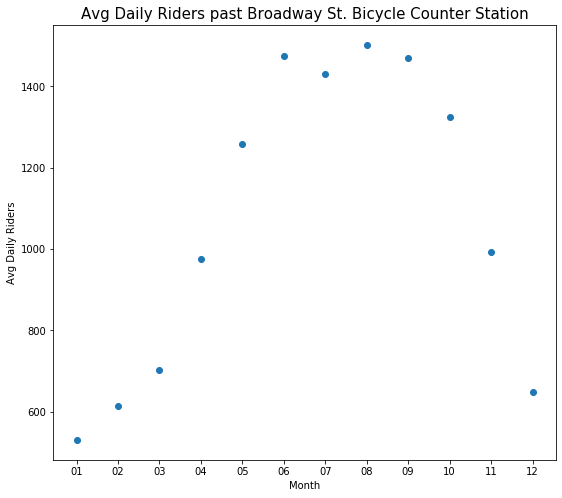

In [11]:
# plot reduced number of data points for month to month bike comparison
plt.scatter(month_bike_count['Month'], month_bike_count['Avg Daily Count'])
plt.xlabel('Month')
plt.ylabel('Avg Daily Riders')
plt.title('Avg Daily Riders past Broadway St. Bicycle Counter Station', fontsize=15)

([<matplotlib.axis.XTick at 0x125da9ef0>,
 <a list of 12 Text xticklabel objects>)

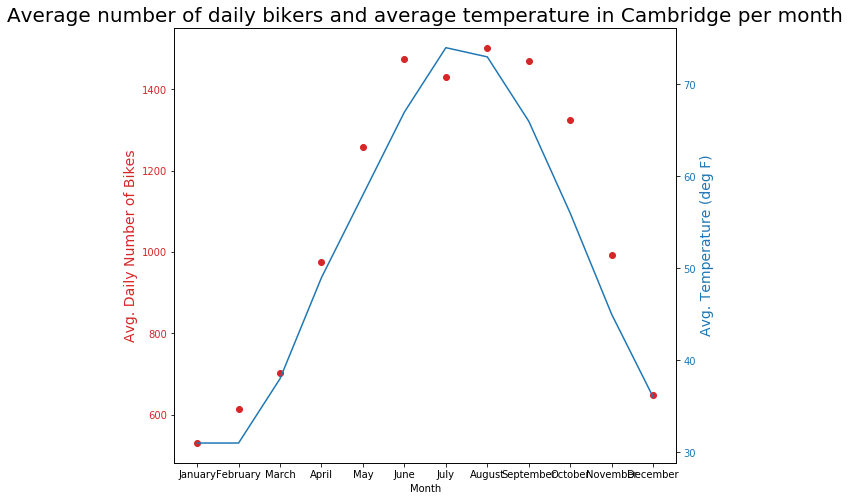

In [12]:
# compare the number of average daily riders per month to the average monthly temperature
# plot number of bikes and average temperature for each month

months = month_bike_count['Month']
bike_count = month_bike_count['Avg Daily Count']
avg_temp = monthly_weather['Avg Temp']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Avg. Daily Number of Bikes', color=color, fontsize=14)
ax1.scatter(months, bike_count, color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.title('Average number of daily bikers and average temperature in Cambridge per month', fontsize=20)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Avg. Temperature (deg F)', color=color, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(monthly_weather['Month Number'], avg_temp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks(np.arange(12), calendar.month_name[1:13])

### There is a clear correlation between monthly temperature and the number of bike riders

## Demographic data of bike commuters in Cambridge

[-0.11318429  1.        ]
[0.35083191 1.        ]
[-0.26005745  1.        ]


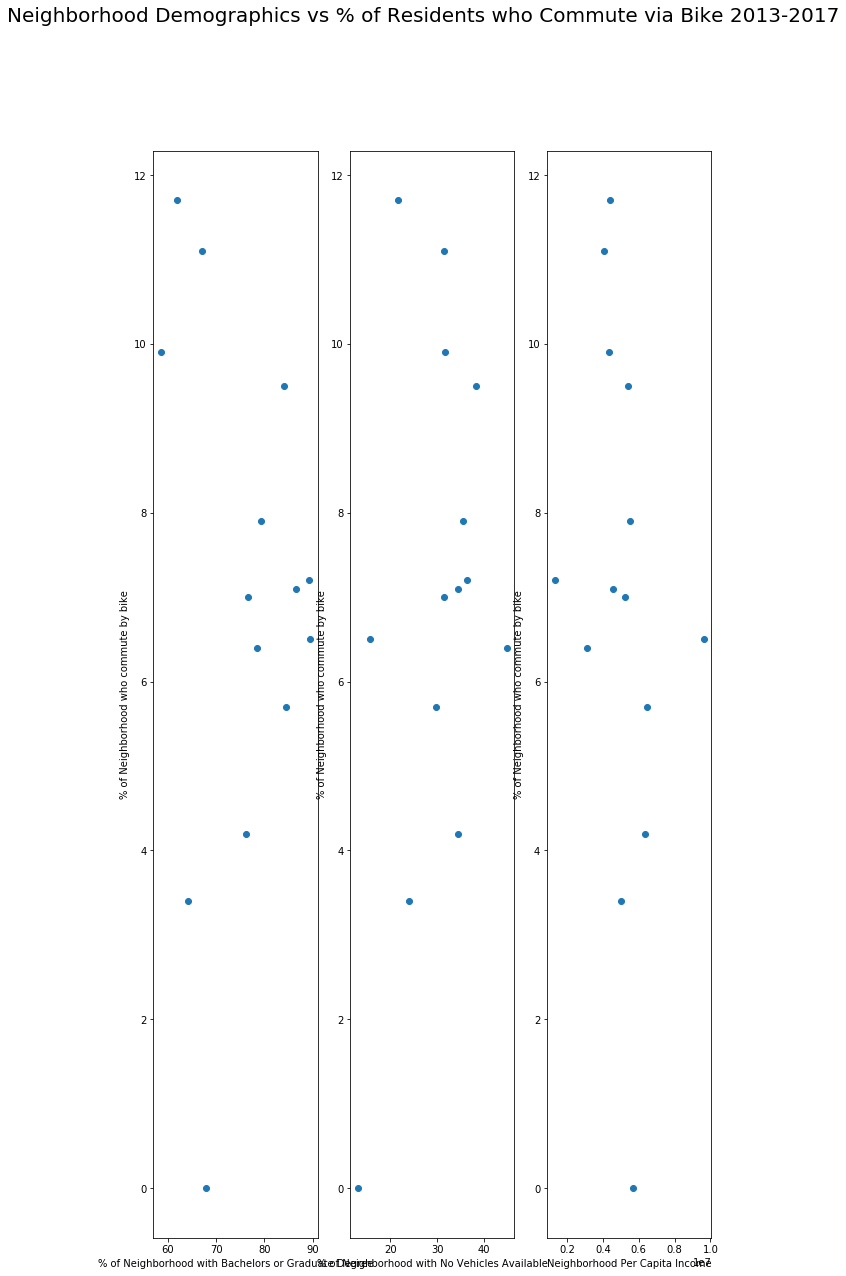

In [40]:
# plot the demographics of bikers in Cambridge vs. % of neighborhood that commutes via bike
# demographics investigated: 
# % with Bachelor or Grad degree, % with no vehicles available, per capita income

# multiply values by 100 to convert from fraction to %
x_list = [nbr_data['Bachelors or Graduate Degrees %']*100, \
          nbr_data['No Vehicles Available %']*100, nbr_data['Per Capita Income']*100]
x_label_list = ['% of Neighborhood with Bachelors or Graduate Degree', \
                '% of Neighborhood with No Vehicles Available', \
                'Neighborhood Per Capita Income']

plt.suptitle('Neighborhood Demographics vs % of Residents who Commute via Bike 2013-2017',\
             fontsize=20)

for i in range(1, 4):
    plt.subplot(1, 3, i)
    x = x_list[(i-1)]
    y = nbr_data['Resident Commute: Bike %']*100
    plt.scatter(x, y)
    plt.xlabel(x_label_list[i-1])
    plt.ylabel('% of Neighborhood who commute by bike')

    # calculate correlation coefficients between % who bike and other demographics
    print( np.corrcoef(x, y)[1])

## A  visual inspection of the effect of different demographic factors (% with bachelor's of graduate degree, % with no vehicle available, per capita income) on the % of neighborhood members who ride their bikes to work does not show strong correlation between any of the different factors. 

# Part 2: Bike safety in Cambridge: Bike Crash Data

In [20]:
# only select crash data that involves a bicyclist
bike_crash_data_all = crash_data.loc[crash_data['May involve cyclist'] == 1.0]

# create new dataframe from selected, relevant columns of crash database
col_list = ['Date Time','Day of Week', 'Ambient Light', 'Weather Condition 1', 'Road Surface Condition', 'v1 State Code']

bike_crash_data = pd.DataFrame()
for element in col_list:
    bike_crash_data[element] = bike_crash_data_all[element]
    
bike_crash_data.head(5)

,Date Time,Day of Week,Ambient Light,Weather Condition 1,Road Surface Condition,v1 State Code
1,01/05/2015 09:15:00 AM,Monday,DAYLIGHT,SEVERE CROSSWINDS,DRY,MA
28,04/23/2015 07:20:00 AM,Thursday,DAYLIGHT,CLEAR,DRY,MA
35,06/06/2015 11:39:00 PM,Saturday,DARK - LIGHTED ROADWAY,CLEAR,DRY,MA
39,07/14/2015 08:27:00 PM,Tuesday,DAYLIGHT,CLEAR,DRY,MA
41,07/22/2015 05:24:00 PM,Wednesday,NaN,NaN,NaN,MA


In [21]:
# create a function that will give you the bike accidents for a given category
def bike_crash_breakdown(crash_dataframe, category_term):
    """
    
    :param crash_dataframe: dataframe you want to select categories from
    :param category_term: category which is the title of a column in the dataframe
    :return: a dictionary contain all values in the selected category and their frequencies
    
    """
    crash_dict = {}
    interest_list = crash_dataframe[category_term]
    for i in range(len(interest_list)):
        inter = interest_list.iloc[i]
        if inter in crash_dict:
            crash_dict[inter] += 1
        else:
            crash_dict[inter] = 1
    return crash_dict

Total crashes since 2015: 734
[[1.         0.95863987]
 [0.95863987 1.        ]]


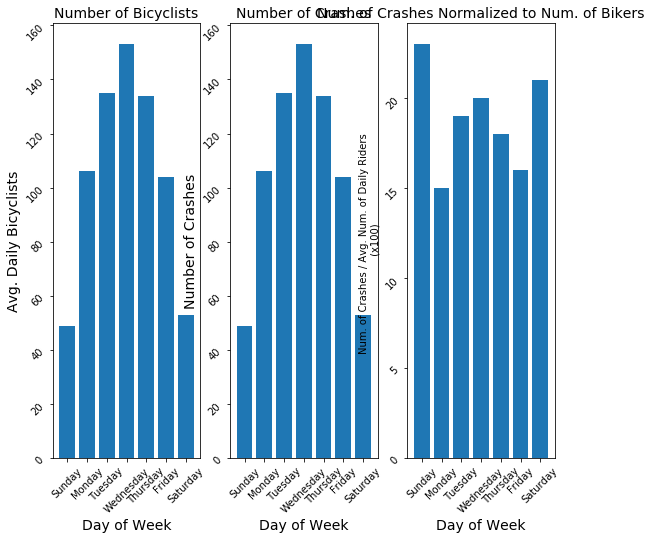

In [22]:
# count the number of bike accidents on each day of the week
dow_count = bike_crash_breakdown(bike_crash_data, 'Day of Week')

# sort dow count, in python 3 insertion order of dictionaries is guaranteed
ordered_dow_count = {'Sunday':0,'Monday': 0, 'Tuesday': 0, 'Wednesday': 0,\
                     'Thursday': 0, 'Friday': 0, 'Saturday': 0}

# rearrage dow_count so the days of the week are in order
total_bike_crashes = 0
for day in dow_count:
    ordered_dow_count[day] = dow_count[day]
    total_bike_crashes += dow_count[day]
    
print('Total crashes since 2015:', total_bike_crashes)

normalized_dow_crash = {}
for day in ordered_dow_count:
    normalized_dow_crash[day] = int(ordered_dow_count[day] / dow_dict_daily[day]*100)

# plot num of bicyclist, num of crashes, and normaized num of crashes
plt.subplot(1,3,1)
plt.bar(list(dow_dict_daily.keys()),list(ordered_dow_count.values()))
plt.title('Number of Bicyclists', fontsize=14)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Avg. Daily Bicyclists', fontsize=14)
plt.tick_params(labelrotation=45)

plt.subplot(1,3,2)
plt.bar(list(ordered_dow_count.keys()),list(ordered_dow_count.values()))
plt.title('Number of Crashes', fontsize=14)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.tick_params(labelrotation=45)

plt.subplot(1,3,3)
plt.bar(list(normalized_dow_crash.keys()),list(normalized_dow_crash.values()))
plt.title('Num. of Crashes Normalized to Num. of Bikers', fontsize=14)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Num. of Crashes / Avg. Num. of Daily Riders \n (x100)')
plt.tick_params(labelrotation=45)

# calculate correlation coefficient between bicyclist per day of week and crashes
x = list(dow_dict_daily.values())
y = list(ordered_dow_count.values())

print(np.corrcoef(x,y))

### More bike accidents happen on weeks day rather than weekends. However, there are also more daily riders on weekdays, so the normalized number of bicycle crashes per day is higher for the weekends.

In [23]:
# function that, give a dictionary with all int values, produces percentages of each value
def dict_percent(int_dict):
    """
    
    :param int_dict: dictionary where values are counts
    :return: per_list: a dictionary where values for each key are % of total counts associated with that key
    
    """
    per_list = {}
    total = sum(int_dict.values())
    for item in int_dict:
        curr_val = round(((int_dict[item] / total)*100),2)
        per_list[item] = curr_val
    return per_list

In [24]:
# determine the frequency of bike crashs in different amounts of ambient light. 
crash_light_count = bike_crash_breakdown(bike_crash_data, 'Ambient Light')
print(crash_light_count)

# combine different conditions to create 3 categories: daylight, dark, dusk/dawn
crash_light_count_brf = {}
crash_light_count_brf['dark'] = crash_light_count['DARK - LIGHTED ROADWAY'] + crash_light_count['DARK - UNKNOWN ROADWAY LIGHTING'] + crash_light_count['DARK - ROADWAY NOT LIGHTED']
crash_light_count_brf['dusk'] = crash_light_count['DUSK'] + crash_light_count['DAWN']
crash_light_count_brf['daylight'] = crash_light_count['DAYLIGHT']
print('\n', crash_light_count_brf)


{'DAYLIGHT': 544, 'DARK - LIGHTED ROADWAY': 117, nan: 6, 'DUSK': 48, 'UNKNOWN': 10, 'DARK - UNKNOWN ROADWAY LIGHTING': 2, 'DAWN': 5, 'DARK - ROADWAY NOT LIGHTED': 1, 'OTHER': 1}

 {'dark': 120, 'dusk': 53, 'daylight': 544}


In [25]:
# now determine as a percentage of total bike related crashes
crash_light_percent = dict_percent(crash_light_count_brf)

print("Percent of Crashes in Ambient Light Types")
print(crash_light_percent)

Percent of Crashes in Ambient Light Types
{'dark': 16.74, 'dusk': 7.39, 'daylight': 75.87}


### The majority of bike crashes happen during day light, however, the majority of bike rides also occur during daylight. The next step investigates whether the percentage of accidents that happen at night is proportional to the percentage of bike rides that happen at night. 

In [26]:
broad_bike_count.head()

,DateTime,Day,Date,Time,Total,Westbound,Eastbound
18336,01/01/2016 12:00:00 AM,Friday,01/01/2016,00:00:00,1,1,0
18406,01/01/2016 05:30:00 PM,Friday,01/01/2016,17:30:00,3,2,1
18405,01/01/2016 05:15:00 PM,Friday,01/01/2016,17:15:00,1,1,0
18404,01/01/2016 05:00:00 PM,Friday,01/01/2016,17:00:00,1,1,0
18403,01/01/2016 04:45:00 PM,Friday,01/01/2016,16:45:00,2,2,0


In [27]:
# this function will determine the percentage of riders who ride in each type of light

def bike_time_counter(dark_end, morn_dusk_end, daylight_end, eve_dusk_end, dataset):
    """
    
    :param dark_end: hour in integer of the time of day dark ends
    :param morn_dusk_end: hour in integer of the time of day morning dusk ends
    :param daylight_end: hour in integer of the time of day daylight ends
    :param eve_dusk_end: hour in integer of the time of day evening dusk ends
    :param dataset: a dataset containing biker counts broken down by time of day
    :return: a dictionary containing the count for bikers riding in each type of light
    
    """
    amb_light_dict = {'dark':0,'dusk':0,'daylight':0}
    all_time = dataset['Time']
    all_count = dataset['Total']
    
    for i in range(len(all_time)): 
        curr_time =  all_time.iloc[i]
        curr_count = all_count.iloc[i]
        curr_time = int(curr_time[1:3])
        
        if dark_end > curr_time or curr_time > eve_dusk_end:
            amb_light_dict['dark'] += curr_count
            
        elif curr_time < morn_dusk_end or curr_time > daylight_end:
            amb_light_dict['dusk'] += curr_count
            
        else:
            amb_light_dict['daylight'] += curr_count
            
    return amb_light_dict       

In [28]:
# for a rough estimate of the number of bikers at each type of light: 
# the number of hours of daylight vary throughout the year, the atumn equinox, Sept. 21 will be used as an estimate
# Sept 21, 2019: night 8:18pm to 4:55am dusk/dawn: 4:55am to 6:30am daylight 6:30am to 6:43pm
#daylight time source: https://www.timeanddate.com/sun/usa/boston?month=9


# create dictionary of the bike counts at different ambient lights
broad_bike_light = bike_time_counter(5, 6, 19, 20, broad_bike_count)

# turn counts into %
broad_light_perc = dict_percent(broad_bike_light)

print('percent of biker riders during each light:', broad_light_perc)

percent of biker riders during each light: {'dark': 5.88, 'dusk': 3.79, 'daylight': 90.33}


In [29]:
# calculate the ratio of bikers to crashs in different types of light
norm_light = []
key_list = []
print('% of crashes / % of total riders:')
for key in broad_light_perc:
    key_list.append(key)
    norm_light.append(round(crash_light_percent[key]/broad_light_perc[key] ,2))
    
print(norm_light)
print(key_list)


% of crashes / % of total riders:
[2.85, 1.95, 0.84]
['dark', 'dusk', 'daylight']


## The ratio of number of bike rides the number of crashes involving bicycles is more than 3 times as high at night as it is during the day. This suggests that bicycle crashes are more likely to happen during dark hours

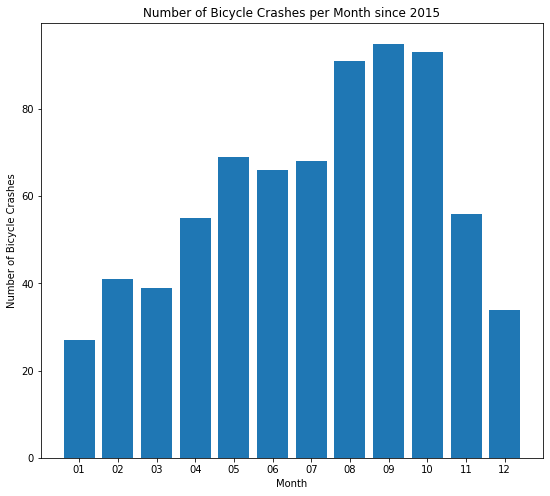

In [30]:
# which month has the most accidents?

# determine the percent of total bicyclists each month
# monthly_average is a dictionary defined above where the values are months 
# and the keys are the average number of daily bikers

# determine the number of bicycle crashes each month
crash_dates = bike_crash_data['Date Time']

# python 3 insertion order is guarenteed, 
#so initialize dict with values to maintain correct order
month_crash_count_dict = {'01':0, '02':0, '03':0, '04':0,'05':0, '06':0, '07':0, '08':0, '09':0, '10':0, '11':0,}
for i in range(len(crash_dates)):
    curr_date = crash_dates.iloc[i] 
    curr_month = curr_date[:2]
    if curr_month in month_crash_count_dict:
        month_crash_count_dict[curr_month] += 1
    else:
        month_crash_count_dict[curr_month] = 1       

plt.bar(month_crash_count_dict.keys(), month_crash_count_dict.values())
plt.xlabel('Month')
plt.ylabel('Number of Bicycle Crashes')
plt.title('Number of Bicycle Crashes per Month since 2015')
month_perc_crashes = dict_percent(month_crash_count_dict)

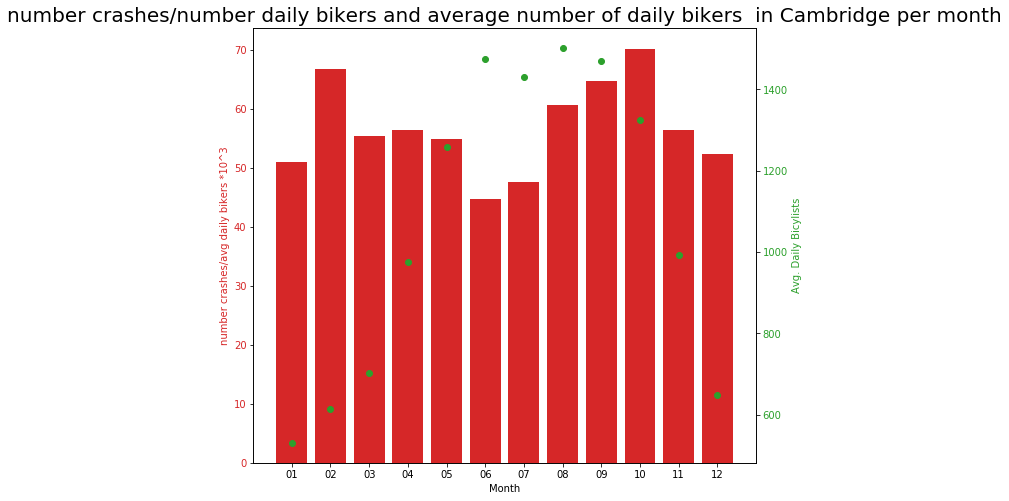

In [31]:
# normalize the number of crashes per month by number of bikers per month
# monthly_crash_count_dict is the number of crashes each month
# monthly_average is the average number of daily bikers per month

norm_crash_month = {}
for i in month_crash_count_dict.keys():
    norm_crash_month[i] = round( month_crash_count_dict[i] / monthly_average[i]*1000 , 2)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('number crashes/avg daily bikers *10^3', color=color)
ax1.bar(norm_crash_month.keys(), norm_crash_month.values(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.title('number crashes/number daily bikers and average number of daily bikers  in Cambridge per month', fontsize=20)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Avg. Daily Bicylists', color=color)  # we already handled the x-label with ax1
ax2.scatter(list(monthly_average.keys()), list(monthly_average.values()), color=color)
ax2.tick_params(axis='y', labelcolor=color)


## The months with highest normalized number of bikers are February and October, these months do not have the highest number of bikers, suggesting that there is not a strong correlation between number of bikers and number of crashes

In [32]:
# now examine weather and crashes
crash_weather_count = bike_crash_breakdown(bike_crash_data, 'Weather Condition 1')
print(dict_percent(crash_weather_count))
print('\n')

crash_road_surface_count = bike_crash_breakdown(bike_crash_data, 'Road Surface Condition')
print(dict_percent(crash_road_surface_count))

{'SEVERE CROSSWINDS': 0.14, 'CLEAR': 71.25, nan: 1.09, 'UNKNOWN': 3.27, 'RAIN': 7.77, 'CLOUDY': 15.67, 'SNOW': 0.27, 'SLEET, HAIL, FREEZING RAIN OR DRIZZLE': 0.41, 'OTHER': 0.14}


{'DRY': 79.97, nan: 2.04, 'UNKNOWN': 3.54, 'WET': 12.67, 'ICE': 0.14, 'SNOW': 0.82, 'SAND, MUD, DIRT, OIL, GRAVEL': 0.41, 'OTHER': 0.41}


## Over 70% of crashes involving bicycles occured when the weather was 'clear' and almost 80% of crashes occured when the road way dry

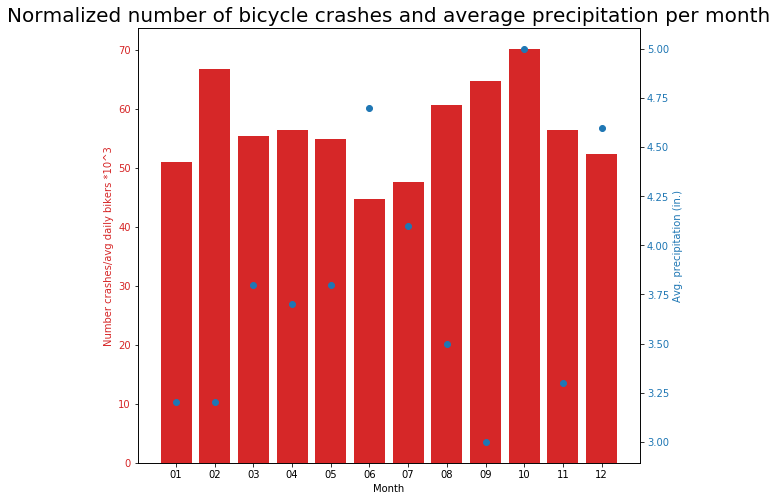

In [33]:
# look at if there is any correlation between normalized number of monthly crashes and average precipitation
precip = list(monthly_weather['Avg Precipitation'])
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Number crashes/avg daily bikers *10^3', color=color)
ax1.bar(norm_crash_month.keys(), norm_crash_month.values(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.title('Normalized number of bicycle crashes and average precipitation per month', fontsize=20)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Avg. precipitation (in.)', color=color)  # we already handled the x-label with ax1
ax2.scatter(list(monthly_average.keys()), precip, color=color)
ax2.tick_params(axis='y', labelcolor=color)


## there does not appear to be a strong correlation between the normalized number of bicycle crashes and the amount of precipitation in a month. However, October is the month with the highest normalized number of crashes and highest amount of precipitation, it is possible that there is a weak correlation between precipitation and normalized crashes. 

In [34]:
# determine if more out of state cars are involved with bicycle crashes
state_license_dict = bike_crash_breakdown(bike_crash_data, 'v1 State Code')

# initialize a dict value that will count total out of state plates
state_license_dict['not MA'] = 0

# count the total number of out of state cars involved in bicycle accidents
# do not count 'nan' as out of state
for state in state_license_dict:
    if state != 'MA' and pd.isnull(state) == False and state != 'not MA':
        state_license_dict['not MA'] += state_license_dict[state]

#calculate percentage of MA and out of state plates
total_crashes_w_plates = state_license_dict['MA'] + state_license_dict['not MA']
ma_percent = round(state_license_dict['MA'] / total_crashes_w_plates *100 ,1)
not_ma_percent = round(state_license_dict['not MA'] / total_crashes_w_plates* 100, 1)

print(state_license_dict['MA'], 'Massachusetts cars were involved in bicycle crashes', \
      '(', ma_percent, '% of crashes)')
print(state_license_dict['not MA'], 'Out of state cars were involved in bicycle crashes', \
      '(', not_ma_percent, '% of crashes)')

617 Massachusetts cars were involved in bicycle crashes ( 90.5 % of crashes)
65 Out of state cars were involved in bicycle crashes ( 9.5 % of crashes)


# interesting that there are a large number of other states, not sure if enough to be statistically signficant, but may be out of state drivers are not used to bikers